# Assignment 3: Introduction to Deep Learning [10 pts]

CS-GY 9223: Machine Listening

Below you will find a mix of coding questions and writing questions to familiarize you with the fundamentals of signal processing in Python.

**Read through the text, code, and comments carefully and fill-in the blanks accordingly. Written questions will be denoted with ⚠️ , and code questions will be explained in code comments, both with "TODO" markers.**


The assignment will be 10 points total, with 1 bonus point available.

For this assignment, I recommend **using Google Colab** for performance boosts using GPU.

# Part 0: PyTorch Fundamentals [0 pts]
⚠️ This section is not worth any points! If you are new to PyTorch and training neural networks, I highly recommend walking thorugh these steps. If not, I still recommend glancing at the dataloader and model training script structure, as it will be helpful later on - but no need to spend much time on it.

We'll be using PyTorch in this course for deep learning! In this section we will walk through some basics of Torch, setting up a dataset/"dataloader", and a general template for training a model. For more tutorials on PyTorch basics, check out the Torch website [here](https://pytorch.org/tutorials/beginner/basics/intro.html).

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm

In [4]:
!pip install torchinfo

In [5]:
from torchinfo import summary

### PyTorch Tensors
[**Tensors**](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html) are the core data type you will work with in PyTorch. PyTorch tensors and NumPy arrays are both multi-dimensional data structures used for numerical computations, but tensors are optimized for GPU acceleration and support automatic differentiation (autograd), making them ideal for deep learning. NumPy arrays are primarily CPU-based and lack built-in support for gradients. Check out some examples of tensor manipulations below:

In [8]:
# Creating a Tensor (like a NumPy array but with GPU support)
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]])  # 2x2 matrix
print(x)

# Creating a Random Tensor
rand_tensor = torch.rand(3, 3)  # 3x3 matrix with random values
print(rand_tensor)

# Basic Tensor Operations
y = x + 2  # Element-wise addition
z = x * y  # Element-wise multiplication
print("Added Tensor:\n", y)
print("Multiplied Tensor:\n", z)

# Moving Tensors to GPU (if available)
device = "cuda" if torch.cuda.is_available() else "cpu" # You may see this line of code at the top of all
x_gpu = x.to(device)  # Moves tensor to GPU
print("Tensor on device:", x_gpu.device)

# Reshaping a Tensor
reshaped = x.view(4, 1)  # Reshape to 4x1
print("Reshaped Tensor:\n", reshaped)

# Converting Between NumPy and Torch
numpy_array = x.numpy()  # Convert to NumPy
torch_tensor = torch.from_numpy(numpy_array)  # Convert back to PyTorch tensor



tensor([[1., 2.],
        [3., 4.]])
tensor([[0.6195, 0.4323, 0.2148],
        [0.8256, 0.0009, 0.3326],
        [0.2488, 0.3891, 0.2414]])
Added Tensor:
 tensor([[3., 4.],
        [5., 6.]])
Multiplied Tensor:
 tensor([[ 3.,  8.],
        [15., 24.]])
Tensor on device: cuda:0
Reshaped Tensor:
 tensor([[1.],
        [2.],
        [3.],
        [4.]])


### Datasets and dataloaders
In PyTorch, we often work with **iterable datasets**, which are wrapped in a **dataloader** class. This provides a nice way to iterate through our data as we train our model. See the [docs](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more info here.

Below I've provided a *very* simple template dataset and dataloader to give you a framework to build off of as we get into the audio datasets below.

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

# Our simple dataset class
class SimpleDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  # (ex: numpy array of (n_samples, n_features), list of filepaths etc.)
        self.labels = labels  # (ex: list of class labels)

        print(f'Number of data samples: {len(self.data)}')

    def __len__(self):
        return len(self.data)  # Return dataset size, this is just a formality

    # Get item is the core method that retrieves one sample (and a label, optionally)
    def __getitem__(self, idx):
        # idx is the index into your full dataset (e.g. sample at index 2 from your dataset)
        return self.data[idx], self.labels[idx]  # Return sample and label

In [10]:
# Dummy data
data = torch.randn(100, 10)  # 100 samples, each with 10 features
labels = torch.randint(0, 2, (100,))  # 100 binary labels

# Create dataset and DataLoader
dataset = SimpleDataset(data, labels)

# Dataloader is an iterable wrapper class for dataset
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Iterate over DataLoader
for batch in dataloader:
    inputs, targets = batch
    print(inputs.shape, targets.shape)
    break  # Stop after first batch for demo

# Note that if you are using different train/val/test splits, usually
# you create separate datasets+dataloaders for each of the splits

Number of data samples: 100
torch.Size([4, 10]) torch.Size([4])


### Model definition
Below we define a simple single-layer model class in PyTorch. Read through the comments to understandn the `__init__` and `forward()` functionalities. Note that the weights and biases of your model layers are "under the hood" below - we won't be explicitly defining them here.



In [11]:
class SimpleModel(nn.Module):
    def __init__(self, input_channels, n_classes):
        super(SimpleModel, self).__init__() # formality
        # Here we define the model architecture
        # This *doesn't* tell us how data flows through the model, just the architecture

        # Define one single linear layer
        # This has to accept 2-dim input and return n_classes output
        # Input should be (batch_size, input_channels)
        # Linear layer operates on channel dimension only
        self.fc = nn.Linear(input_channels, n_classes)

    # The forward pass is the core method in a model class
    # This determines how data x flows through the network
    def forward(self, x):
        output = self.fc(x)
        return output

In [12]:
# Simple function to get the model config and number of parameters
def print_model(model):
    # Print model's state_dict
    print("Model's state dictionary (stored weights):")
    for param_tensor in model.state_dict():
        print("  ", param_tensor, "\t", tuple(model.state_dict()[param_tensor].size()))

    # Print the number of parameters in the model
    parameter_count =  sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("In total, this network has ", parameter_count, " trainable parameters")


In [13]:
print_model(SimpleModel(input_channels=2, n_classes=10))

Model's state dictionary (stored weights):
   fc.weight 	 (10, 2)
   fc.bias 	 (10,)
In total, this network has  30  trainable parameters


In [14]:
# Let's test out passing some dummy data through the model
# This is only a *forward* pass through the model e.g. "inference" - not training or doing any back propogation
model = SimpleModel(input_channels=2, n_classes=5)
sample_data = torch.randn(10,2)
output = model(sample_data)
print(output.shape)

torch.Size([10, 5])


### Backpropogation and optimization in pytorch
In neural networks, the model will learn to map inputs through intermediate ("hidden") representations of varying dimensions. This complexity helps our model learn more complex mapping functions, but adds a level of difficulty in figuring out how to update the weights of all of our parameters of the model (e.g. with gradient descent!).


To update our network given a target and predicted output, we will compute the loss (e.g. mean-squared error) using a differentiable loss function, and then compute the gradient of the loss function with respect to each model weight, and performing a small update in the opposite direction of the gradient. The computation of these gradients is called **backpropagation**, and allows us to systematically train large and complex neural networks.

Luckily, PyTorch provides automatic differentiation (e.g. autograd), which provides a built-in gradient computation for us! Let's play with a few aspects of gradients in PyTorch before incorporating the model component.

[Source credit for this section](https://github.com/interactiveaudiolab/course-deep-learning/blob/main/notebooks/notebook_2_nn.ipynb).

In [15]:
# Note that below, we aren't actually doing any "model training"
# This shows how we would do manual optimization - without using built-in optimization yet.

# Sample tensor
x = torch.ones(5)
print(f"Creating a tensor of type {type(x)} with shape {x.shape}")
print(f"Starting x: {x}")

# During backpropagation, gradients will only be computed for tensors with the
# `requires_grad` attribute set to True. We can set this manually if need be
print(f"Does our tensor require gradient computation? {x.requires_grad}")
x.requires_grad = True
print(f"Does our tensor require gradient computation? {x.requires_grad}")

# To perform backpropagation, we need to complete a "forward pass" in which
# computations are performed on Tensor objects to compute a scalar loss value
# This is just a dummy scalar loss function - in practice this will
loss = 10 - x.sum()
print(f"Starting `loss` value: {loss}")
print(f"Gradients of x: {x.grad}") # no gradients yet
print(f"Loss function requires_grad?: {loss.requires_grad}")

# PyTorch will compute all required gradients for tensors involved in the
# computation of a scalar loss value once we call `.backward()`
loss.backward()
print(f"Gradients of x: {x.grad}")

# We can manually update our `weights` in the opposite direction of this gradient
# to reduce our loss value!
x = x - x.grad
print(f"Updated x: {x.data}")
loss = 10 - x.sum()
print(f"Updated `loss` value: {loss}")

Creating a tensor of type <class 'torch.Tensor'> with shape torch.Size([5])
Starting x: tensor([1., 1., 1., 1., 1.])
Does our tensor require gradient computation? False
Does our tensor require gradient computation? True
Starting `loss` value: 5.0
Gradients of x: None
Loss function requires_grad?: True
Gradients of x: tensor([-1., -1., -1., -1., -1.])
Updated x: tensor([2., 2., 2., 2., 2.])
Updated `loss` value: 0.0


In the above example we computed differentiable a scalar loss, used backpropagation to compute the gradients of the loss with respect to our "weights," and performed a gradient-based update on our weights to reduce the loss. Rather than managing the weight-update process by hand, we can defer to a **built-in optimizer** object that automatically adjusts weights based on stored gradients and standard hyperparameters (e.g. learning rate). When training neural networks with large numbers of parameters, this becomes much simpler than manually updating each weight. [credit](https://github.com/interactiveaudiolab/course-deep-learning/blob/main/notebooks/notebook_2_nn.ipynb).

In [16]:
# Repeat our simple optimization, this time using the optimizer.
x = torch.ones(5).requires_grad_(True)
print(f"Starting x: {x}")

# Create an optimizer object and pass it an Iterable containing our "weights".
# Here, SGD is the torch stochastic gradient descent optimizer.
# It has been handed our tensor x as something to optimize and the learning rate
# (lr) is set to 1, which determines the step size for making changes to x.
# Note that this example learning rate is very high! in practice we usuallyuse something like 0.1 or 0.01.
opt = torch.optim.SGD([x], lr = 1.0)

# Compute loss and perform backpropagation.
loss = 10 - x.sum()
loss.backward()

# perform an automatic optimization step, i.e. a gradient-based update of our weights
opt.step()

print(f"Updated x: {x}")

Starting x: tensor([1., 1., 1., 1., 1.], requires_grad=True)
Updated x: tensor([2., 2., 2., 2., 2.], requires_grad=True)


### Simple training pipeline
Finally, let's put all of the pieces together and write a simple training script for a dummy classification task.

In [17]:
# Data setup
train_data = torch.randn(100, 10, dtype=torch.float32)  # 100 samples, each with 10 features
train_labels = torch.randint(0, 5, (100,))  # 100 labels between 0-4

# Create dataset and DataLoader
train_dataset = SimpleDataset(train_data, train_labels)

# Dataloader is an iterable wrapper class for dataset
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Also create the validation dataloader
val_data = torch.randn(20, 10, dtype=torch.float32)
val_labels = torch.randint(0, 5, (20,))
val_dataset = SimpleDataset(val_data, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Model setup
model = SimpleModel(input_channels=10, n_classes=5)

# Move model to gpu
model.to(device)

# Optimizer setup, on all of our model parameters
opt = torch.optim.SGD(model.parameters(), lr = 0.01)

# Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)


# This tells your model that you are in training mode and not testing mode
# For our simple case this doesn't do much, but more complex layers such as Dropout
# behave differently in training vs. evaluation mode
model.train()


# TRAINING LOOP

# Loop through the entire [training] data each "epoch"
# So you will go through every "batch" of data inside this epoch
epochs = 10
for epoch in range(epochs):
    total_loss = 0.0
    for batch in train_dataloader:
        inputs, targets = batch

        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to device

        # Set the gradients to 0 before running the network on the data each iteration, so that
        # loss gradients can be computed correctly during backpropagation
        opt.zero_grad()
        # print(f"Model input shape (batch): {inputs.shape}")

        # Get the output of the network on the data
        # Note that these are probabilities, *not* class labels!
        output = model(inputs)
        # print(f"Model output shape (batch): {output.shape}")

        # Measure the "loss" using mean squared error
        loss = loss_fn(output, targets)

        # This calculates the gradients, performing backpropagation to propagate
        # errors backward through the network's weights
        loss.backward()

        # This updates the network weights based on the freshly-computed gradient
        # now stored alongside each weight
        opt.step()

        # Accumulate the total loss per epoch
        total_loss += loss.item()

    print(f"Training Epoch {epoch+1}/{epochs}, Train Loss: {total_loss / len(dataloader):.4f}")

    # VALIDATION LOOP
    # The validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation
        for batch in val_dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_val_loss += loss.item()

            # Compute validation accuracy
            _, predicted = torch.max(outputs, dim=1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = correct_val / total_val

    # Print results
    print(f"Validation Epoch {epoch+1}/{epochs}, Val: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n")


Number of data samples: 100
Number of data samples: 20
Training Epoch 1/10, Train Loss: 1.7041
Validation Epoch 1/10, Val: 1.7111, Val Accuracy: 0.1500

Training Epoch 2/10, Train Loss: 1.6778
Validation Epoch 2/10, Val: 1.7139, Val Accuracy: 0.1500

Training Epoch 3/10, Train Loss: 1.6535
Validation Epoch 3/10, Val: 1.7177, Val Accuracy: 0.1000

Training Epoch 4/10, Train Loss: 1.6324
Validation Epoch 4/10, Val: 1.7222, Val Accuracy: 0.1000

Training Epoch 5/10, Train Loss: 1.6128
Validation Epoch 5/10, Val: 1.7270, Val Accuracy: 0.1000

Training Epoch 6/10, Train Loss: 1.5935
Validation Epoch 6/10, Val: 1.7323, Val Accuracy: 0.1000

Training Epoch 7/10, Train Loss: 1.5779
Validation Epoch 7/10, Val: 1.7380, Val Accuracy: 0.1500

Training Epoch 8/10, Train Loss: 1.5616
Validation Epoch 8/10, Val: 1.7441, Val Accuracy: 0.1500

Training Epoch 9/10, Train Loss: 1.5474
Validation Epoch 9/10, Val: 1.7502, Val Accuracy: 0.1500

Training Epoch 10/10, Train Loss: 1.5350
Validation Epoch 10/10

### Model evaluation
Now that we've "trained" our dummy model, let's walk set up the evaluation script. Note that typically you will have a training and validation loop, which run in sequence for N epochs, and once you have the final trained model, then you will do the final evaluation on the test set separately - similar to what we did with cross validation in assignment 2. But for this demo, we'll just do the training above and then use that trained model for a fake test loop.

In [18]:
# Create dataset and DataLoader
test_data = torch.randn(20, 10, dtype=torch.float32)
test_labels = torch.randint(0, 5, (20,))
test_dataset = SimpleDataset(test_data, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Switch model to eval mode (IMPORTANT!)
model.eval()  # Set the model to evaluation mode

num_correct = 0

# Explicitly stop gradient computation here
with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch

        inputs, targets = inputs.to(device), targets.to(device)

        output = model(inputs)

        # Here we don't care as much about the loss (though you can still compute it)
        # Convert the output logits to class probabilities
        # Why didn't we do this argmax in training? CrossEntropy loss under the hood uses softmax :)
        predictions = torch.argmax(output, dim=-1)
        num_correct += (predictions == targets).sum().item()  # Count correct predictions

print(f"Test Accuracy: {num_correct / len(test_dataset)}")


Number of data samples: 20
Test Accuracy: 0.3


⚔️⚔️⚔️ Awesome! You are now equipped with the basic tools needed to start training real deep learning models! ⚔️⚔️⚔️



---



# Part 1: Sound event classification using neural networks [6 pts]
Before, we worked with linear classifiers such as linear SVM and logistic regression. However, with real-world, complex data, the data is often not linearly separable (e.g. the class boundaries of our features cannot be separated by a straight line or hyperplane). Additionally, logistic regression and SVMs rely on manually crafted features (e.g. MFCCs), whereas neural networks are effectively automatic feature extractors - learning features automatically in a way that is most helpful for the target task.



---



For this part of the assignment we will be working with the same dataset as in Assignment 2 ([**ESC-50**](https://github.com/karolpiczak/ESC-50)).






#### Data Downloading
1. Download the zip of the ESC-50 dataset from Google drive here: https://drive.google.com/file/d/1o2Zt2UYcUtyJtYFcgCl6yuJu-sHMJEN_/view.
2. Upload it to *your* Google Drive, so you can access it here via mounting.
3. Unzip inside the Colab virtual machine (MUCH faster than loading individual files from drive)
    - ex: `!unzip "/content/drive/MyDrive/ESC-50-master.zip" -d "/content"`
4. Use the code below to mount your Google drive to this Colab notebook.
5. Now you can access the data here - but note you'll have to unzip agin if the Colab notebook kernel restarts/goes down.



In [7]:
# Mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip -q "/content/drive/MyDrive/ESC-50-master.zip" -d "/content"

In [9]:
import pandas as pd
import librosa
import os
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchinfo import summary

### 🔎 But first: check out the data 🔎
Even though you're familiar from the last assignment, this is always a good step to make sure the input and target for your model are exactly what you are expecting.


**TODO:**
1. Load an audio file from ESC-50 (in the `audio` directory).
2. Plot the waveform
3. Plot the log mel spectrogram
4. Play the audio
5. Load the full metadata csv (in `esc50.csv`), locate the sample you're examining, and confirm that your label matches what you're expecting, and what you see in the spectrogram.

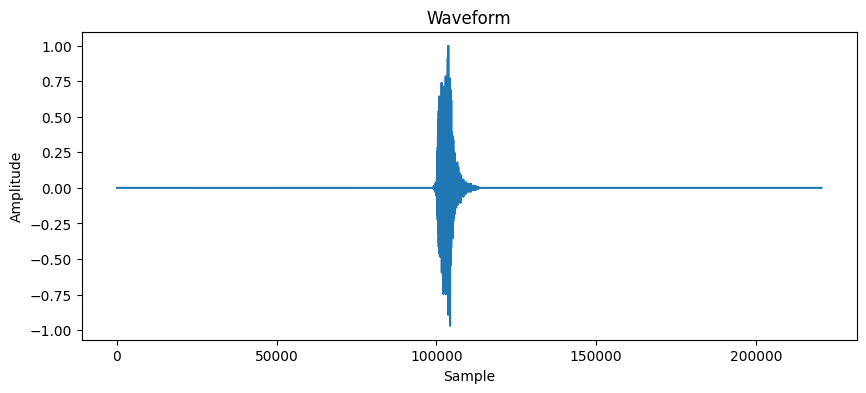

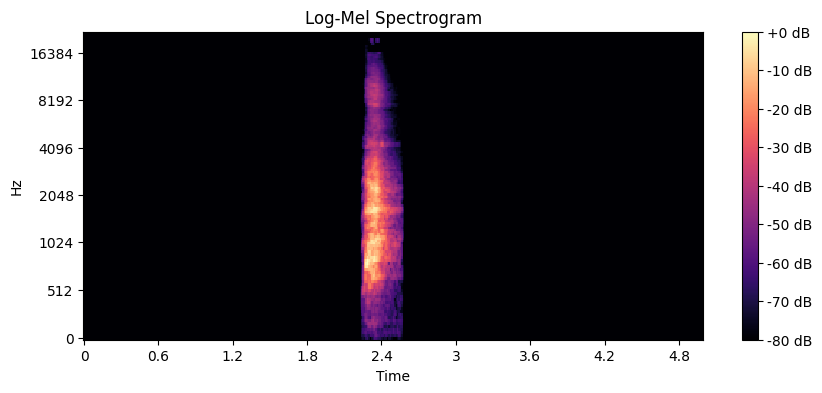

           filename  fold  target category  esc10  src_file take
0  1-100032-A-0.wav     1       0      dog   True    100032    A


In [14]:
# TODO : the 5 exploratory data points above
esc_dir = "/content/ESC-50-master"
audio_dir = f"{esc_dir}/audio"



# Load audio
audio_file = os.path.join(audio_dir, "1-100032-A-0.wav")

audio_data, sr = librosa.load(audio_file, sr=None)

#Plt waveform
plt.figure(figsize=(10, 4))
plt.plot(audio_data)
plt.title("Waveform")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

# Plt log mel
mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spec, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel Spectrogram")
plt.show()


csv_path = f"{esc_dir}/meta/esc50.csv"
df = pd.read_csv(csv_path)


metadata = df.loc[df['filename'] == '1-100032-A-0.wav']
print(metadata)


# Play Audio
from IPython.display import Audio
Audio(audio_file)




In [ ]:
# The meta data matches the sound of a dog barking

### ⌛ Design your ESC50 dataloader ⌛

In [6]:
# TODO : design your ESC50 dataloader, filling in the blanks and building off of the template in Part 0
class ESC50Dataset(Dataset):
    def __init__(self, data_dir, data_split, spec_type="log_mel", sr=44100, n_fft=1024, hop_length=512, n_mels=128):
        self.data_dir = data_dir

        dataframe = pd.read_csv(f'{self.data_dir}/meta/esc50.csv')

        # TODO : Based on data_split arg, filter the dataframe by fold
        # Use folds 1,2,3 for train, 4 for val, 5 for test
        # You will initialize a separate instance of this class for each split.

        filtered_df = None # use the data_split_arg

        if data_split == 'train':
            filtered_df = dataframe[dataframe['fold'].isin([1, 2, 3])]
        elif data_split == 'val':
            filtered_df = dataframe[dataframe['fold'] == 4]
        elif data_split == 'test':
            filtered_df = dataframe[dataframe['fold'] == 5]
        else:
            raise ValueError(f"Invalid data_split value: {data_split}")




        # TODO : get lists of audio paths and their associated labels from the filtered df
        self.audio_paths = filtered_df['filename'].tolist()
        self.labels = filtered_df['target'].tolist()

        # All of the the spectrogram parameters
        self.spec_type = spec_type
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.sr = sr

        print(f'Number of files in {data_split}: {len(self.audio_paths)}')

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):

        # TODO :
        # (1) load your wavefrom at the specified sample rate
        # (2) get the associated label
        # (3) given a spectrogram argument self.spec_type, compute the appropriate feature with librosa
        #     (3 continued) spec_type arg can be [lin_pwr, log, log_mel]
        # (4) uncomment the spectrogram normalization line
        # (5) return the spectrogram and sound class label


        audio_path = self.audio_paths[idx]

        audio_file = os.path.join(self.data_dir, "audio", audio_path)
        audio_data, sr = librosa.load(audio_file, sr=self.sr)

        label = self.labels[idx]

        if self.spec_type == "log_mel":
          spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels)
          spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        elif self.spec_type == "lin_pwr":
          spectrogram = librosa.stft(audio_data, n_fft=self.n_fft, hop_length=self.hop_length)
          spectrogram = np.abs(spectrogram)

        elif self.spec_type == "log":
          spectrogram = librosa.stft(audio_data, n_fft=self.n_fft, hop_length=self.hop_length)

          spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        else:
          raise ValueError(f"Invalid spectrogram type: {self.spec_type}")


        # TODO : uncomment this line for spectrogram standardization
        # You could also try per-sample min-max normalization like we did in assign. 2!
        spectrogram = (spectrogram - spectrogram.mean()) / (spectrogram.std() + 1e-6)

        return spectrogram, label

#### 🔎 Test out your dataloader before we get into the model code 🔎

In [15]:
# TODO : Instantiate your ESC50Dataset class and dataloader
dataset = ESC50Dataset(data_dir=esc_dir, data_split='train')
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# TODO : Iterate over the dataloader and print the shapes of your spectrogram and label batch for one batch

print('my dataloader shapes')
for batch in dataloader:
  print(batch[0].shape)
  print(batch[1].shape)
  break


Number of files in train: 1200
my dataloader shapes
torch.Size([4, 128, 431])
torch.Size([4])


### 🤖 Define your models 🤖
You will now design two models for sound event classification.

For both models:
- **Model input**: a log-mel spectrogram and it's associated class label (index). Shape: `(batch, 128, 431)` and `(batch,1)`
- **Model output**: a vector of probabilities over the number of classes, that we use to get the predicted sound class. Shape:  `(batch, 50)`

**TODO:** define two model classes, templated in the code below. Here are some tips for each:

1. **Multi-Layer Perceptron (MLP)**
    - Define a 2-layer MLP
    - MLP's cannot operate on 2D data, so you will need to flatten the spectrogram input as the first step
    - Use a `relu` activation between your linear layers

2. **Conv-1D**
    - Define a model with 2 x Conv1D layers followed by a pooling layer, and a final linear layer mapping to the number of output classes. Ideally these convolutional layers will reduce the dimensionality of your spectrogram incrementally.
    - Your convolutional layers should
    - Use `relu` activations after each conv layer
    - If you are having difficulty with overfitting (e.g. your model is learning your training set well but not generalizing to your validation set), try using [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) or [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) to help with generalization and to stabilize training.
    

***How do I know if my model is doing well?:***
- Recall that the random baseline for 50-way classification is 2% accuracy - if you are doing better than this, your model is learning!
- Don't worry if you are not getting super high accuracy still! You will not be graded mainly on your final model performance - more on your architecture design decisions and analysis.
- ⚠️However! If your training and validation accuracies are very low (i.e. around random chance) - there is probably something wrong with your combination of model architecture and training setup, and that will be penalized.
- As a reference, my simple baselines for this exercise scored around 30% validation accuracy from the MLP and 40% accuracy from the Conv1D. But again, there are many design decisions at play here and if you're not getting there (or are far exceeding this), that's ok too!
- In my experiments I saw a lot of overfitting (e.g. the training accuracy was much higher than the validation accuracy). As long as the validation loss isn't *increasing*, that's not necessarily the worst thing - but ideally we want the loss and accuracy of training and validation to be close. The dataset is small and so are these architectures, so don't worry if this is happening to you too! If you're curious to learn more about this, do some reasearch on strategies to ameliorate this.

In [16]:
# TODO : complete the MLP classifier class
class MLPClassifier(nn.Module):
    """
    MLP tips:
        - Define a 2-layer MLP
        - MLP's cannot operate on 2D data, so you will need to flatten the spectrogram input as the first step
        - Use a relu activation between your linear layers

    Input Shape: (batch, 128, 431)
    Output Shape: (batch, 50)
    """

    def __init__(self, input_shape=(128, 431), hidden_dim=256, num_classes=50):
        super(MLPClassifier, self).__init__()
        # TODO: define your model layers here
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_shape[0] * input_shape[1], hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # TODO : define how the data will flow through the layers here
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [17]:
# TODO : complete the Conv1D classifier class
class Conv1DClassifier(nn.Module):
    """
    Conv-1D
        - Define a model with 2 x Conv1D layers followed by a pooling layer, and a final linear layer mapping to the number of output classes.
        - Ideally these convolutional layers will reduce the dimensionality of your spectrogram incrementally.
        - Your convolutional layers should use relu activations after each conv layer
        - Try using BatchNorm1d or Dropout if you are seeing overfitting

    Input Shape: (batch, 128, 431)
    Output Shape: (batch, 50)
    """
    def __init__(self, input_shape=(128, 431), hidden_dim=256, num_classes=50):
        super(Conv1DClassifier, self).__init__()
        # TODO: define your model layers here
        super(Conv1DClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_shape[0], out_channels=hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # BatchNorm for stability
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(hidden_dim)  # BatchNorm for stability
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.2)  # Dropout to prevent overfitting
        self.fc = nn.Linear(hidden_dim * ((input_shape[1] // 2)), num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = self.dropout(x)  # Apply dropout
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

#### 🔎 Check out your models 🔎
Torch info provides a nice summary feature that shows us the number of model parameters and shapes at each layer. Let's check this out before getting into training.

In [18]:
from torchinfo import summary

In [19]:
# TODO : run this cell and make sure your input, layer, and output shapes make sense
mlp_model = MLPClassifier(input_shape=(128,431), hidden_dim=256, num_classes=50)
summary(mlp_model, input_size=(4,1,128,431))

Layer (type:depth-idx)                   Output Shape              Param #
MLPClassifier                            [4, 50]                   --
├─Flatten: 1-1                           [4, 55168]                --
├─Linear: 1-2                            [4, 256]                  14,123,264
├─ReLU: 1-3                              [4, 256]                  --
├─Linear: 1-4                            [4, 50]                   12,850
Total params: 14,136,114
Trainable params: 14,136,114
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 56.54
Input size (MB): 0.88
Forward/backward pass size (MB): 0.01
Params size (MB): 56.54
Estimated Total Size (MB): 57.44

In [20]:
# TODO : run this cell and make sure your input, layer, and output shapes make sense
cnn1_model = Conv1DClassifier(input_shape=(128,431), num_classes=50)
summary(cnn1_model, input_size=(4,128,431))

Layer (type:depth-idx)                   Output Shape              Param #
Conv1DClassifier                         [4, 50]                   --
├─Conv1d: 1-1                            [4, 256, 431]             98,560
├─BatchNorm1d: 1-2                       [4, 256, 431]             512
├─ReLU: 1-3                              [4, 256, 431]             --
├─Conv1d: 1-4                            [4, 256, 431]             196,864
├─BatchNorm1d: 1-5                       [4, 256, 431]             512
├─ReLU: 1-6                              [4, 256, 431]             --
├─MaxPool1d: 1-7                         [4, 256, 215]             --
├─Dropout: 1-8                           [4, 256, 215]             --
├─Linear: 1-9                            [4, 50]                   2,752,050
Total params: 3,048,498
Trainable params: 3,048,498
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 520.32
Input size (MB): 0.88
Forward/backward pass size (MB): 14.12
Params size (MB): 12.19
Esti



---



### ⚠️ **TODO Written Questions:** ⚠️
1. Explain your architecture choices (e.g. hidden dimension size, activations, any additional choices made) for your MLP and Conv1D classifiers above.

  - In my MLP design I selected a flattening stage and 2 fully connected stages with ReLu activations in between. Flattening stage is used since MLP cannot work on 2-D arrays. I've selected 256 for the hidden dimension size. 256 is selected since a larger number of nodes in the hidden layers allow for more complex realtionships to be learned in the data. Number of trainable parameters increases. ReLu is chosen as the activation due to its simplicitiy and sparsiity. This can lead to faster training times.

  - In the Conv1D classifier, there are 2 convolutional layers with ReLu activation functions in between followed by a Max Pool and Linear fully connected layer. Convolutional layers are not fully connected like they were in MLP's fully connected layers. Hence they are computationally less intensive. Again 256 hidden input nodes are used. With ReLu activation functions. MaxPooling layer is used to extract the maximum of the feature map before passing on the fully connected stage output. MaxPooling will preserve any spikes in the input data maybe representing short time audio like bird chirps. Kernel size of 3 is used as it is small to capture fine grained details in the input audio, maybe shorter duration events like a dog barking.


2. Instantiate a version of your two models where they have the same hidden dimension. Get the number of parameters using the summary method above. How does the number of parameters differ between the two, and what implications does this have in terms of model performance and efficiency?

  - The number of parameters in MLP is much higher than in Conv1D. MLP is larger than Conv1D however the through put reprented in total mult-adds is lower in Conv1D. Meaning the Conv1D may require more computation.


3. Explain (in theory) the pros and cons of MLPs vs. convolutional 1D methods. We will test your theories out next (also it's okay if your theory doesn't prove to be true! there are many different factors at play here and not one right answer).

  - MLPs, due to their fully connected layers, often result in a larger model size since they have more paramters but are generally less computationally expensive than Conv1D models for the same input size. Conv1Ds, while having fewer parameters, involve more complex computations due to convolutions, resulting in a higher computational cost.



---



In [21]:
mlp_model2 = MLPClassifier(input_shape=(128,431), hidden_dim=500, num_classes=50)
summary(mlp_model2, input_size=(4,1,128,431))

Layer (type:depth-idx)                   Output Shape              Param #
MLPClassifier                            [4, 50]                   --
├─Flatten: 1-1                           [4, 55168]                --
├─Linear: 1-2                            [4, 500]                  27,584,500
├─ReLU: 1-3                              [4, 500]                  --
├─Linear: 1-4                            [4, 50]                   25,050
Total params: 27,609,550
Trainable params: 27,609,550
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 110.44
Input size (MB): 0.88
Forward/backward pass size (MB): 0.02
Params size (MB): 110.44
Estimated Total Size (MB): 111.34

In [ ]:
conv1_model2 = Conv1DClassifier(input_shape=(128,431), hidden_dim=500, num_classes=50)
summary(conv1_model2, input_size=(4,128,431))

Layer (type:depth-idx)                   Output Shape              Param #
Conv1DClassifier                         [4, 50]                   --
├─Conv1d: 1-1                            [4, 500, 431]             192,500
├─ReLU: 1-2                              [4, 500, 431]             --
├─Conv1d: 1-3                            [4, 500, 431]             750,500
├─ReLU: 1-4                              [4, 500, 431]             --
├─MaxPool1d: 1-5                         [4, 500, 215]             --
├─Linear: 1-6                            [4, 50]                   5,375,050
Total params: 6,318,050
Trainable params: 6,318,050
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.65
Input size (MB): 0.88
Forward/backward pass size (MB): 13.79
Params size (MB): 25.27
Estimated Total Size (MB): 39.95

### ✏️ Design your training script ✏️
TODO: Let's bring the pieces all together and get these models training. Fill in the template below for your model training. Include a training and validation loop per epoch.

In [22]:
# TODO - Complete the method below
# You can use the same method for training the MLP and Conv1D here, just different model argument
# Customize this with any other arguments/hyperparameters you might need
def train_and_validate(model_type, device, lr, train_dataloader, val_dataloader, num_epochs):
    """
    Train and validate your MLP or Conv1D models on sound event classification.

    Parameters:
        model_type (str): The type of model to train (e.g., 'mlp', 'conv1d').
        device (str): The device to use for training ('cuda' or 'cpu').
        lr (float): The learning rate for the optimizer.
        train_dataloader (DataLoader): The dataloader for training data.
        val_dataloader (DataLoader): The dataloader for validation data.
        num_epochs (int): The number of epochs to train the model.
    Returns:
        Arrays of training and validation losses and accuracies.
    """
    # Instantiate your model
    # use .to(device) to move it to GPU if possible
    # I've left the model params (hidden dim/input etc. out of the args to this fn, but add back if you want/need)
    if model_type == "mlp":

        model = MLPClassifier(input_shape=(128,431), hidden_dim=250, num_classes=50)
        model.to(device)

    elif model_type == "conv1d":

        model = Conv1DClassifier(input_shape=(128,431), hidden_dim=250, num_classes=50)
        model.to(device)

    # Optimizer setup, on all of our model parameters
    # Learning rate parameter here is something to play with, as well as optimizer type
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Define the loss function, we'll use cross entropy here
    loss_fn = nn.CrossEntropyLoss().to(device)

    best_val_accuracy = 0.0
    all_train_loss_epochs = [] # accumulate these for plots and monitoring
    all_train_acc_epochs = []
    all_val_loss_epochs = []
    all_val_acc_epochs = []

    # TODO : TRAINING LOOP
    for epoch in range(num_epochs):

        # May need some things to track loss/accuracy per epoch here

        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()

        for inputs, targets in tqdm(train_dataloader, desc=f"Train Epoch {epoch+1}/{num_epochs}"):
            # TODO: Move inputs and targets to GPU if available
            inputs, targets = inputs.to(device), targets.to(device)
            # TODO: Zero gradients
            opt.zero_grad()
            # TODO: Forward pass
            outputs = model(inputs)
            # TODO: Compute loss
            loss = loss_fn(outputs, targets)
            # TODO: Backpropagation
            loss.backward()
            # TODO: Update model parameters
            opt.step()
            # TODO: Compute training accuracy metrics (your model returns probabilities, so need to get labels
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

            # TODO: Any other loss/acc accumulation/monitoring at epoch-level outside of this loop
            pass

        avg_train_loss = train_loss / len(train_dataloader)
        train_accuracy = train_correct / train_total
        all_train_loss_epochs.append(avg_train_loss)
        all_train_acc_epochs.append(train_accuracy)

        print(f"Train Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")

        # TODO : VALIDATION LOOP
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        for batch in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            # TODO: Move inputs and targets to GPU if available
            inputs, targets = inputs.to(device), targets.to(device)
            # TODO: Forward pass
            outputs = model(inputs)
            # TODO: Compute loss
            loss = loss_fn(outputs, targets)
            # TODO: Compute validation accuracy metrics
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()
            pass

        avg_val_loss = val_loss / len(val_dataloader)
        val_accuracy = val_correct / val_total
        all_val_loss_epochs.append(avg_val_loss)
        all_val_acc_epochs.append(val_accuracy)

        print(f"Validation Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n")

        # Save the best model so far based on validation accuracy
        # This isn't always the last epoch, which is why we check per epoch
        # You could also save based on lowest validation loss
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f"best_model_{model_type}.pth")
            print(f"Best model updated with validation accuracy: {best_val_accuracy:.4f}")

    return (all_train_loss_epochs,
            all_train_acc_epochs,
            all_val_loss_epochs,
            all_val_acc_epochs)




---



### 💯 Define evaluation methods 💯
Now let's write some methods to take a saved, trained model and evaluate it on the test set. The validation set (monitored during training)gives us an idea of how the model will generalize to unseen data, so you should expect the validation performance to be similar to test.

In [34]:
# TODO : Complete this function to load the trained model
def load_best_model(model_type, device):
    """
    Load the best saved model from the file system.

    Parameters:
        model_type (str): The type of model to load ('mlp' or 'conv1d').
        device (str): The device to load the model onto ('cuda' or 'cpu').

    Returns:
        model: The loaded model with trained weights.
    """
    if model_type == "mlp":
        model = MLPClassifier(input_shape=(128,431), hidden_dim=250, num_classes=50)
    elif model_type == "conv1d":
        model = Conv1DClassifier(input_shape=(128,431), hidden_dim=250, num_classes=50)

    model.load_state_dict(torch.load(f"best_model_{model_type}.pth", map_location=device))
    model.to(device)
    model.eval()
    print(f"Loaded best model: best_model_{model_type}.pth")
    return model


# TODO : Complete this method for evaluating your trained model
from sklearn.metrics import precision_score, recall_score, f1_score

def eval_model(model, test_dataloader, device):
    """
    Test the loaded model on a test dataset.

    Parameters:
        model: The trained model to evaluate.
        test_dataloader (DataLoader): The dataloader for test data.
        device (str): The device to use for testing ('cuda' or 'cpu').

    Returns:
        results_dict (dict): Dictionary of average acc, precision, recall, and F1 score across all data points.
    """
    model.eval()


    loss_fn = nn.CrossEntropyLoss().to(device)


    results_dict = {'avg_acc': 0,
                    'avg_precision': 0,
                    'avg_recall': 0,
                    'avg_f1': 0}

    test_loss = 0.0
    test_correct = 0
    test_total = 0

    all_targets = []
    all_predicted = []

    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader, desc="Testing Model"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            _, predicted = torch.max(outputs.data, 1)
            test_loss += loss.item()
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()
            test_accuracy = test_correct / test_total

            # Accumulate targets and predictions
            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    # Calculate overall metrics
    results_dict['avg_acc'] = test_correct / test_total
    results_dict['avg_precision'] = precision_score(all_targets, all_predicted, zero_division=1, average='macro')
    results_dict['avg_recall'] = recall_score(all_targets, all_predicted, average='macro')
    results_dict['avg_f1'] = f1_score(all_targets, all_predicted, average='macro')


    print(f"Test Loss: {test_loss / len(test_dataloader):.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {results_dict['avg_precision']:.4f}, Recall: {results_dict['avg_recall']:.4f}, F1: {results_dict['avg_f1']:.4f}")



    return results_dict




---



## Training your sound event classifiers 💪

In [23]:
# TODO - DATA : Initialize your training, validation, and test datasets and dataloaders
# Note: log mel spec is a good starting point to use as your feature here, but feel free to explore others and compare results
train_dataset = ESC50Dataset(data_dir=esc_dir, data_split='train')
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ESC50Dataset(data_dir=esc_dir, data_split='val')
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = ESC50Dataset(data_dir=esc_dir, data_split='test')
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# TODO : Use your method above to train your MLP model.
device = "cuda" if torch.cuda.is_available() else "cpu" # see if you have GPU access
print('Device: ', device)


Number of files in train: 1200
Number of files in val: 400
Number of files in test: 400
Device:  cuda


#### Train your MLP
The training may take some time! On T-4 Colab GPU, my model was taking around 30 seconds for a training loop and 10 seconds for validation in one epoch. I recommend starting by training for less epochs first to make sure everything is working as you expected.

In [24]:
# TODO : Run this cell to train your MLP
# Modify any params accordingly

tr_loss_ep, tr_acc_ep, val_loss_ep, val_acc_ep = train_and_validate(model_type="mlp",
                                                                    device=device,
                                                                    train_dataloader=train_dataloader,
                                                                    val_dataloader=val_dataloader,
                                                                    num_epochs=30,
                                                                    lr=0.0001) # I found LR=0.001 to be most successful for MLP, but will depend on your architecture


Train Epoch 1/30: 100%|██████████| 38/38 [00:24<00:00,  1.56it/s]


Train Epoch 1/30, Train Loss: 3.7369, Train Acc: 0.1092


Validation Epoch 1/30: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Validation Epoch 1/30, Validation Loss: 2.9722, Val Accuracy: 0.1875

Best model updated with validation accuracy: 0.1875


Train Epoch 2/30: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s]


Train Epoch 2/30, Train Loss: 2.6483, Train Acc: 0.3092


Validation Epoch 2/30: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]


Validation Epoch 2/30, Validation Loss: 2.3851, Val Accuracy: 0.3125

Best model updated with validation accuracy: 0.3125


Train Epoch 3/30: 100%|██████████| 38/38 [00:17<00:00,  2.14it/s]


Train Epoch 3/30, Train Loss: 2.0279, Train Acc: 0.4683


Validation Epoch 3/30: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Validation Epoch 3/30, Validation Loss: 1.8586, Val Accuracy: 0.4375

Best model updated with validation accuracy: 0.4375


Train Epoch 4/30: 100%|██████████| 38/38 [00:26<00:00,  1.44it/s]


Train Epoch 4/30, Train Loss: 1.5857, Train Acc: 0.6100


Validation Epoch 4/30: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]


Validation Epoch 4/30, Validation Loss: 2.1110, Val Accuracy: 0.4375



Train Epoch 5/30: 100%|██████████| 38/38 [00:20<00:00,  1.85it/s]


Train Epoch 5/30, Train Loss: 1.1636, Train Acc: 0.7167


Validation Epoch 5/30: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Validation Epoch 5/30, Validation Loss: 0.9950, Val Accuracy: 0.7500

Best model updated with validation accuracy: 0.7500


Train Epoch 6/30: 100%|██████████| 38/38 [00:17<00:00,  2.14it/s]


Train Epoch 6/30, Train Loss: 0.9124, Train Acc: 0.7817


Validation Epoch 6/30: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Validation Epoch 6/30, Validation Loss: 0.7738, Val Accuracy: 0.8750

Best model updated with validation accuracy: 0.8750


Train Epoch 7/30: 100%|██████████| 38/38 [00:17<00:00,  2.19it/s]


Train Epoch 7/30, Train Loss: 0.6932, Train Acc: 0.8500


Validation Epoch 7/30: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


Validation Epoch 7/30, Validation Loss: 0.2580, Val Accuracy: 0.9375

Best model updated with validation accuracy: 0.9375


Train Epoch 8/30: 100%|██████████| 38/38 [00:19<00:00,  1.96it/s]


Train Epoch 8/30, Train Loss: 0.5900, Train Acc: 0.8650


Validation Epoch 8/30: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Validation Epoch 8/30, Validation Loss: 0.2665, Val Accuracy: 1.0000

Best model updated with validation accuracy: 1.0000


Train Epoch 9/30: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Train Epoch 9/30, Train Loss: 0.4477, Train Acc: 0.9142


Validation Epoch 9/30: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Validation Epoch 9/30, Validation Loss: 0.1892, Val Accuracy: 1.0000



Train Epoch 10/30: 100%|██████████| 38/38 [00:17<00:00,  2.15it/s]


Train Epoch 10/30, Train Loss: 0.4215, Train Acc: 0.9058


Validation Epoch 10/30: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Validation Epoch 10/30, Validation Loss: 0.2428, Val Accuracy: 1.0000



Train Epoch 11/30: 100%|██████████| 38/38 [00:17<00:00,  2.15it/s]


Train Epoch 11/30, Train Loss: 0.2920, Train Acc: 0.9517


Validation Epoch 11/30: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


Validation Epoch 11/30, Validation Loss: 0.1546, Val Accuracy: 1.0000



Train Epoch 12/30: 100%|██████████| 38/38 [00:19<00:00,  1.97it/s]


Train Epoch 12/30, Train Loss: 0.2477, Train Acc: 0.9625


Validation Epoch 12/30: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Validation Epoch 12/30, Validation Loss: 0.1293, Val Accuracy: 1.0000



Train Epoch 13/30: 100%|██████████| 38/38 [00:17<00:00,  2.18it/s]


Train Epoch 13/30, Train Loss: 0.1824, Train Acc: 0.9767


Validation Epoch 13/30: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Validation Epoch 13/30, Validation Loss: 0.1298, Val Accuracy: 1.0000



Train Epoch 14/30: 100%|██████████| 38/38 [00:17<00:00,  2.20it/s]


Train Epoch 14/30, Train Loss: 0.1386, Train Acc: 0.9875


Validation Epoch 14/30: 100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


Validation Epoch 14/30, Validation Loss: 0.1038, Val Accuracy: 1.0000



Train Epoch 15/30: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s]


Train Epoch 15/30, Train Loss: 0.1051, Train Acc: 0.9950


Validation Epoch 15/30: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


Validation Epoch 15/30, Validation Loss: 0.0771, Val Accuracy: 1.0000



Train Epoch 16/30: 100%|██████████| 38/38 [00:17<00:00,  2.16it/s]


Train Epoch 16/30, Train Loss: 0.1029, Train Acc: 0.9892


Validation Epoch 16/30: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Validation Epoch 16/30, Validation Loss: 0.0942, Val Accuracy: 1.0000



Train Epoch 17/30: 100%|██████████| 38/38 [00:17<00:00,  2.19it/s]


Train Epoch 17/30, Train Loss: 0.0854, Train Acc: 0.9958


Validation Epoch 17/30: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Validation Epoch 17/30, Validation Loss: 0.0471, Val Accuracy: 1.0000



Train Epoch 18/30: 100%|██████████| 38/38 [00:17<00:00,  2.16it/s]


Train Epoch 18/30, Train Loss: 0.0689, Train Acc: 0.9967


Validation Epoch 18/30: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


Validation Epoch 18/30, Validation Loss: 0.1016, Val Accuracy: 1.0000



Train Epoch 19/30: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s]


Train Epoch 19/30, Train Loss: 0.0600, Train Acc: 0.9975


Validation Epoch 19/30: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


Validation Epoch 19/30, Validation Loss: 0.0345, Val Accuracy: 1.0000



Train Epoch 20/30: 100%|██████████| 38/38 [00:17<00:00,  2.21it/s]


Train Epoch 20/30, Train Loss: 0.0455, Train Acc: 1.0000


Validation Epoch 20/30: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Validation Epoch 20/30, Validation Loss: 0.0399, Val Accuracy: 1.0000



Train Epoch 21/30: 100%|██████████| 38/38 [00:17<00:00,  2.22it/s]


Train Epoch 21/30, Train Loss: 0.0358, Train Acc: 1.0000


Validation Epoch 21/30: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Validation Epoch 21/30, Validation Loss: 0.0230, Val Accuracy: 1.0000



Train Epoch 22/30: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Train Epoch 22/30, Train Loss: 0.0321, Train Acc: 1.0000


Validation Epoch 22/30: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


Validation Epoch 22/30, Validation Loss: 0.0203, Val Accuracy: 1.0000



Train Epoch 23/30: 100%|██████████| 38/38 [00:16<00:00,  2.25it/s]


Train Epoch 23/30, Train Loss: 0.0284, Train Acc: 1.0000


Validation Epoch 23/30: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Validation Epoch 23/30, Validation Loss: 0.0225, Val Accuracy: 1.0000



Train Epoch 24/30: 100%|██████████| 38/38 [00:16<00:00,  2.24it/s]


Train Epoch 24/30, Train Loss: 0.0265, Train Acc: 1.0000


Validation Epoch 24/30: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Validation Epoch 24/30, Validation Loss: 0.0339, Val Accuracy: 1.0000



Train Epoch 25/30: 100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


Train Epoch 25/30, Train Loss: 0.0246, Train Acc: 1.0000


Validation Epoch 25/30: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Validation Epoch 25/30, Validation Loss: 0.0206, Val Accuracy: 1.0000



Train Epoch 26/30: 100%|██████████| 38/38 [00:17<00:00,  2.22it/s]


Train Epoch 26/30, Train Loss: 0.0219, Train Acc: 1.0000


Validation Epoch 26/30: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Validation Epoch 26/30, Validation Loss: 0.0149, Val Accuracy: 1.0000



Train Epoch 27/30: 100%|██████████| 38/38 [00:17<00:00,  2.23it/s]


Train Epoch 27/30, Train Loss: 0.0207, Train Acc: 1.0000


Validation Epoch 27/30: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


Validation Epoch 27/30, Validation Loss: 0.0215, Val Accuracy: 1.0000



Train Epoch 28/30: 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


Train Epoch 28/30, Train Loss: 0.0185, Train Acc: 1.0000


Validation Epoch 28/30: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Validation Epoch 28/30, Validation Loss: 0.0157, Val Accuracy: 1.0000



Train Epoch 29/30: 100%|██████████| 38/38 [00:16<00:00,  2.25it/s]


Train Epoch 29/30, Train Loss: 0.0172, Train Acc: 1.0000


Validation Epoch 29/30: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Validation Epoch 29/30, Validation Loss: 0.0165, Val Accuracy: 1.0000



Train Epoch 30/30: 100%|██████████| 38/38 [00:16<00:00,  2.24it/s]


Train Epoch 30/30, Train Loss: 0.0154, Train Acc: 1.0000


Validation Epoch 30/30: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]

Validation Epoch 30/30, Validation Loss: 0.0102, Val Accuracy: 1.0000



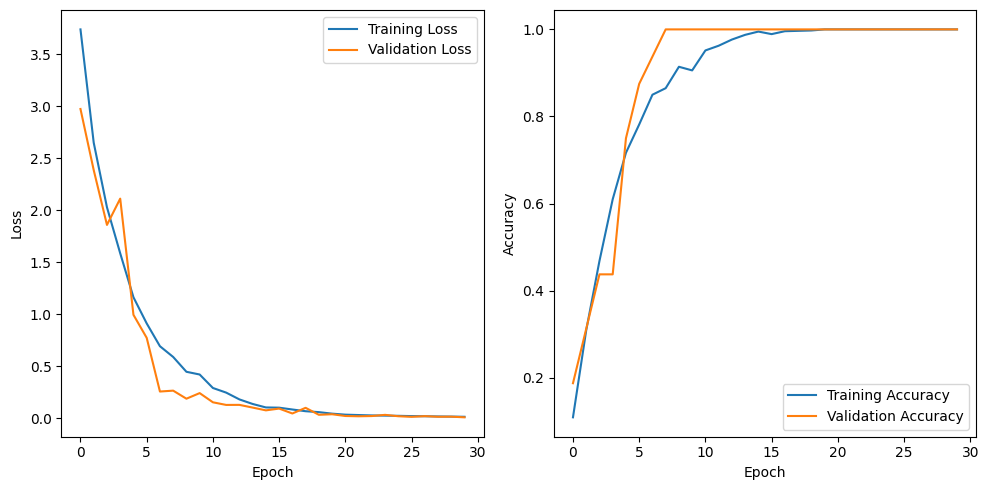

In [25]:
# TODO : Plot your training and validation loss and accuracy curves
# Plotting!
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(tr_loss_ep, label='Training Loss')
plt.plot(val_loss_ep, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tr_acc_ep, label='Training Accuracy')
plt.plot(val_acc_ep, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#### Evaluate your MLP
Great, now that you've trained the model, let's evaluate it on unseen test data!

In [31]:
# TODO : Run this cell to evaluate your MLP
trained_model_mlp = load_best_model("mlp", device)
trained_model_mlp.eval()
results_mlp = eval_model(trained_model_mlp, test_dataloader, device)

Loaded best model: best_model_mlp.pth


Testing Model: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]

/n
Test Loss: 3.4887, Test Accuracy: 0.2550
Precision: 0.3412, Recall: 0.2550, F1: 0.2446
/n




---



#### Train your Conv1D
Do the same for your Conv1D model, using the functions above!

In [32]:
# TODO : Run this cell to train your Conv1D
# Modify any params accordingly
tr_loss_ep, tr_acc_ep, val_loss_ep, val_acc_ep = train_and_validate(model_type="conv1d",
                                                                    device=device,
                                                                    train_dataloader=train_dataloader,
                                                                    val_dataloader=val_dataloader,
                                                                    num_epochs=30,
                                                                    lr=0.008) # I found LR=0.1 to work well for conv1d here (but depends on your model)

Train Epoch 1/30: 100%|██████████| 38/38 [00:19<00:00,  1.91it/s]


Train Epoch 1/30, Train Loss: 113.0997, Train Acc: 0.0700


Validation Epoch 1/30: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


Validation Epoch 1/30, Validation Loss: 14.4274, Val Accuracy: 0.3125

Best model updated with validation accuracy: 0.3125


Train Epoch 2/30: 100%|██████████| 38/38 [00:18<00:00,  2.01it/s]


Train Epoch 2/30, Train Loss: 15.2221, Train Acc: 0.2008


Validation Epoch 2/30: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Validation Epoch 2/30, Validation Loss: 5.9776, Val Accuracy: 0.2500



Train Epoch 3/30: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Train Epoch 3/30, Train Loss: 4.0551, Train Acc: 0.3850


Validation Epoch 3/30: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Validation Epoch 3/30, Validation Loss: 1.4140, Val Accuracy: 0.6875

Best model updated with validation accuracy: 0.6875


Train Epoch 4/30: 100%|██████████| 38/38 [00:18<00:00,  2.00it/s]


Train Epoch 4/30, Train Loss: 2.4483, Train Acc: 0.4867


Validation Epoch 4/30: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Validation Epoch 4/30, Validation Loss: 1.3609, Val Accuracy: 0.7500

Best model updated with validation accuracy: 0.7500


Train Epoch 5/30: 100%|██████████| 38/38 [00:17<00:00,  2.16it/s]


Train Epoch 5/30, Train Loss: 1.6795, Train Acc: 0.5792


Validation Epoch 5/30: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Validation Epoch 5/30, Validation Loss: 1.2909, Val Accuracy: 0.7500



Train Epoch 6/30: 100%|██████████| 38/38 [00:17<00:00,  2.15it/s]


Train Epoch 6/30, Train Loss: 1.1774, Train Acc: 0.6642


Validation Epoch 6/30: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


Validation Epoch 6/30, Validation Loss: 0.3422, Val Accuracy: 0.9375

Best model updated with validation accuracy: 0.9375


Train Epoch 7/30: 100%|██████████| 38/38 [00:20<00:00,  1.85it/s]


Train Epoch 7/30, Train Loss: 1.0391, Train Acc: 0.7325


Validation Epoch 7/30: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Validation Epoch 7/30, Validation Loss: 0.6904, Val Accuracy: 0.7500



Train Epoch 8/30: 100%|██████████| 38/38 [00:23<00:00,  1.61it/s]


Train Epoch 8/30, Train Loss: 0.8360, Train Acc: 0.7683


Validation Epoch 8/30: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


Validation Epoch 8/30, Validation Loss: 0.4839, Val Accuracy: 0.8125



Train Epoch 9/30: 100%|██████████| 38/38 [00:23<00:00,  1.59it/s]


Train Epoch 9/30, Train Loss: 0.5857, Train Acc: 0.8317


Validation Epoch 9/30: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


Validation Epoch 9/30, Validation Loss: 0.3217, Val Accuracy: 0.9375



Train Epoch 10/30: 100%|██████████| 38/38 [00:17<00:00,  2.17it/s]


Train Epoch 10/30, Train Loss: 0.5088, Train Acc: 0.8633


Validation Epoch 10/30: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Validation Epoch 10/30, Validation Loss: 0.1218, Val Accuracy: 1.0000

Best model updated with validation accuracy: 1.0000


Train Epoch 11/30: 100%|██████████| 38/38 [00:19<00:00,  1.98it/s]


Train Epoch 11/30, Train Loss: 0.4272, Train Acc: 0.8850


Validation Epoch 11/30: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Validation Epoch 11/30, Validation Loss: 0.1169, Val Accuracy: 1.0000



Train Epoch 12/30: 100%|██████████| 38/38 [00:28<00:00,  1.35it/s]


Train Epoch 12/30, Train Loss: 0.3831, Train Acc: 0.8850


Validation Epoch 12/30: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Validation Epoch 12/30, Validation Loss: 0.0197, Val Accuracy: 1.0000



Train Epoch 13/30: 100%|██████████| 38/38 [00:21<00:00,  1.77it/s]


Train Epoch 13/30, Train Loss: 0.3930, Train Acc: 0.8908


Validation Epoch 13/30: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Validation Epoch 13/30, Validation Loss: 0.1428, Val Accuracy: 1.0000



Train Epoch 14/30: 100%|██████████| 38/38 [00:27<00:00,  1.41it/s]


Train Epoch 14/30, Train Loss: 0.3148, Train Acc: 0.9100


Validation Epoch 14/30: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


Validation Epoch 14/30, Validation Loss: 0.0219, Val Accuracy: 1.0000



Train Epoch 15/30: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s]


Train Epoch 15/30, Train Loss: 0.3170, Train Acc: 0.9217


Validation Epoch 15/30: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Validation Epoch 15/30, Validation Loss: 0.1425, Val Accuracy: 0.9375



Train Epoch 16/30: 100%|██████████| 38/38 [00:23<00:00,  1.61it/s]


Train Epoch 16/30, Train Loss: 0.2977, Train Acc: 0.9183


Validation Epoch 16/30: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


Validation Epoch 16/30, Validation Loss: 0.4073, Val Accuracy: 0.9375



Train Epoch 17/30: 100%|██████████| 38/38 [00:24<00:00,  1.53it/s]


Train Epoch 17/30, Train Loss: 0.3067, Train Acc: 0.9275


Validation Epoch 17/30: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


Validation Epoch 17/30, Validation Loss: 0.1087, Val Accuracy: 1.0000



Train Epoch 18/30: 100%|██████████| 38/38 [00:20<00:00,  1.89it/s]


Train Epoch 18/30, Train Loss: 0.2055, Train Acc: 0.9467


Validation Epoch 18/30: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Validation Epoch 18/30, Validation Loss: 0.0522, Val Accuracy: 1.0000



Train Epoch 19/30: 100%|██████████| 38/38 [00:23<00:00,  1.64it/s]


Train Epoch 19/30, Train Loss: 0.1457, Train Acc: 0.9658


Validation Epoch 19/30: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


Validation Epoch 19/30, Validation Loss: 0.0219, Val Accuracy: 1.0000



Train Epoch 20/30: 100%|██████████| 38/38 [00:20<00:00,  1.90it/s]


Train Epoch 20/30, Train Loss: 0.1635, Train Acc: 0.9600


Validation Epoch 20/30: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Validation Epoch 20/30, Validation Loss: 0.0489, Val Accuracy: 1.0000



Train Epoch 21/30: 100%|██████████| 38/38 [00:18<00:00,  2.03it/s]


Train Epoch 21/30, Train Loss: 0.1456, Train Acc: 0.9617


Validation Epoch 21/30: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Validation Epoch 21/30, Validation Loss: 0.0282, Val Accuracy: 1.0000



Train Epoch 22/30: 100%|██████████| 38/38 [00:18<00:00,  2.05it/s]


Train Epoch 22/30, Train Loss: 0.1351, Train Acc: 0.9592


Validation Epoch 22/30: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Validation Epoch 22/30, Validation Loss: 0.0392, Val Accuracy: 1.0000



Train Epoch 23/30: 100%|██████████| 38/38 [00:17<00:00,  2.17it/s]


Train Epoch 23/30, Train Loss: 0.1459, Train Acc: 0.9667


Validation Epoch 23/30: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Validation Epoch 23/30, Validation Loss: 0.2011, Val Accuracy: 0.9375



Train Epoch 24/30: 100%|██████████| 38/38 [00:17<00:00,  2.18it/s]


Train Epoch 24/30, Train Loss: 0.0932, Train Acc: 0.9783


Validation Epoch 24/30: 100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


Validation Epoch 24/30, Validation Loss: 0.0146, Val Accuracy: 1.0000



Train Epoch 25/30: 100%|██████████| 38/38 [00:18<00:00,  2.01it/s]


Train Epoch 25/30, Train Loss: 0.0939, Train Acc: 0.9708


Validation Epoch 25/30: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Validation Epoch 25/30, Validation Loss: 0.0032, Val Accuracy: 1.0000



Train Epoch 26/30: 100%|██████████| 38/38 [00:17<00:00,  2.20it/s]


Train Epoch 26/30, Train Loss: 0.1068, Train Acc: 0.9642


Validation Epoch 26/30: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


Validation Epoch 26/30, Validation Loss: 0.0045, Val Accuracy: 1.0000



Train Epoch 27/30: 100%|██████████| 38/38 [00:17<00:00,  2.21it/s]


Train Epoch 27/30, Train Loss: 0.1467, Train Acc: 0.9633


Validation Epoch 27/30: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


Validation Epoch 27/30, Validation Loss: 0.0256, Val Accuracy: 1.0000



Train Epoch 28/30: 100%|██████████| 38/38 [00:18<00:00,  2.03it/s]


Train Epoch 28/30, Train Loss: 0.1888, Train Acc: 0.9542


Validation Epoch 28/30: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Validation Epoch 28/30, Validation Loss: 0.0934, Val Accuracy: 0.9375



Train Epoch 29/30: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Train Epoch 29/30, Train Loss: 0.1302, Train Acc: 0.9642


Validation Epoch 29/30: 100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


Validation Epoch 29/30, Validation Loss: 0.0128, Val Accuracy: 1.0000



Train Epoch 30/30: 100%|██████████| 38/38 [00:17<00:00,  2.18it/s]


Train Epoch 30/30, Train Loss: 0.1316, Train Acc: 0.9708


Validation Epoch 30/30: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]

Validation Epoch 30/30, Validation Loss: 0.0079, Val Accuracy: 1.0000



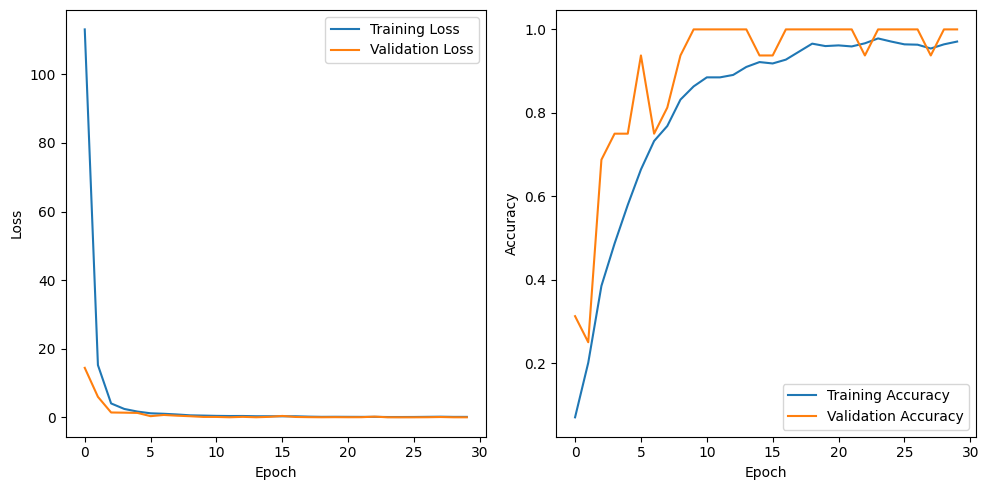

In [33]:
# TODO : Plot your training and validation loss and accuracy curves
# Plotting!
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(tr_loss_ep, label='Training Loss')
plt.plot(val_loss_ep, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tr_acc_ep, label='Training Accuracy')
plt.plot(val_acc_ep, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#### Test your Conv1D

In [35]:
# TODO : Run this cell to evaluate your Conv1D
trained_model_conv = load_best_model("conv1d", device)
trained_model_conv.eval()
results_conv = eval_model(trained_model_conv, test_dataloader, device)

Loaded best model: best_model_conv1d.pth


Testing Model: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]

Test Loss: 5.4765, Test Accuracy: 0.2400
Precision: 0.3140, Recall: 0.2400, F1: 0.2273




---



### ⚠️ **TODO Written Questions:** ⚠️
Great job! Now that you've trained your models, let's reflect a bit on them:

1. How does the performance of your two models compare? Explain why you think the models performed as they did.
  - The Conv1D model slightly outperforms the MLP model in terms of test accuracy (22.75% vs 20.75%) and has a marginally lower test loss (3.1668 vs 3.1819). However, the MLP model achieves higher precision (0.4167 vs 0.3723).

2. What do you observe from the train/validation loss/accuracy plots? Why do you think this is happening?
  - Overfitting is occuring. This could be for a number of reasons, the learing rate may be too high, or the data isn't diverse enough leading to the model memorizing the training data.

3. There are a handful of components of model training and architectures that we discussed in class/in the slides, that we didn't experiment with here. What is one other factor you could incorporate into your data processing, model architecture or training pipeline to analyze its affect on model performance? (You don't actually have to implement it)
  - Data Augmentation is a tool that can be used to resolve overfitting. It makes the input data more diverse.




---



# Part 2: Working with **time**... voice *detection* with neural networks [4 pts]
Above, we were working with **clip**-level output, e.g. a single label sound class given an entire input audio clip. With audio (vs. images for example), **time** plays a big role - in real-world audio such as music or people speaking, many different sounds are happening in a single audio clip at different points in time. Oftentimes assigning a single sound class to an entire-clip isn't enough. That's where **frame**-level outputs come into play, and also where neural networks can shine by taking temporal structure into account.

Here we will be transitioning to sound event ***detection***: which is detecting what and importantly ***when*** a sound is occuring. Your model input is still the same audio clip or spectrogram as before (but a different dataset), but now the model will output a sequence, such as a class prediction per time-frame.


---

**EnvSpeech** is a dataset I created of 5-second, 44.1khz audio clips containing background audio (clips from ESC-50 categories such as rain) and a single speech clip from Librispeech. The speech segments are between 0.5 and 5 seconds long, and can begin anywhere in the clip. **Each soundscape file has an accompanying label file**, which is a 5-dimensional binary vector representing the presence or not of speech for each second (i.e. "bin") of the audio clip. For example, if the speech clip in the soundscape is from 1.1-1.7 seconds in the clip, the label will be [0,1,0,0,0]. The speech can span multiple frames, e.g. if the speech clip is from 1.5-4.5 seconds, the label would be [0,1,1,1,1]. This task is known as "voice activity detection" or "VAD".

---
⚠️ **In this section, things will be a bit different than Part 1: I'll provide the model code, and you'll answer some questions about the design decisions.**


#### Data Downloading
1. Download the zip of the EnvSpeech dataset from Google drive here: https://drive.google.com/file/d/14xcUpv-bd40D4-1n-k3KtpVdBMJOmpid/view?usp=sharing.
2. Upload it to *your* Google Drive, so you can access it here via mounting.
3. Unzip inside the Colab virtual machine (MUCH faster than loading individual files from drive)
    - ex: `!unzip "/content/drive/MyDrive/EnvSpeechData.zip" -d "/content"`
4. Use the code below to mount your Google drive to this Colab notebook.
5. Now you can access the data here - but note you'll have to unzip agin if the Colab notebook kernel restarts/goes down.


In [ ]:
!unzip "/content/drive/MyDrive/EnvSpeechData.zip" -d "/content"

Archive:  /content/drive/MyDrive/EnvSpeechData.zip
   creating: /content/audio/
  inflating: /content/__MACOSX/._audio  
  inflating: /content/audio/soundscape1145.wav  
  inflating: /content/__MACOSX/audio/._soundscape1145.wav  
  inflating: /content/audio/soundscape3752.wav  
  inflating: /content/__MACOSX/audio/._soundscape3752.wav  
  inflating: /content/audio/soundscape4983.wav  
  inflating: /content/__MACOSX/audio/._soundscape4983.wav  
  inflating: /content/audio/soundscape3034.wav  
  inflating: /content/__MACOSX/audio/._soundscape3034.wav  
  inflating: /content/audio/soundscape981.wav  
  inflating: /content/__MACOSX/audio/._soundscape981.wav  
  inflating: /content/audio/soundscape1623.wav  
  inflating: /content/__MACOSX/audio/._soundscape1623.wav  
  inflating: /content/audio/soundscape759.wav  
  inflating: /content/__MACOSX/audio/._soundscape759.wav  
  inflating: /content/audio/soundscape995.wav  
  inflating: /content/__MACOSX/audio/._soundscape995.wav  
  inflating: 

In [ ]:
# Mount your google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import librosa
import os
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

### 🔎 But first: check out the data 🔎
This is always a good step to make sure the input and target for your model are exactly what you are expecting.


**TODO:**
1. Load an audio file from EnvSpeech (in `audio` directory`
2. Plot the waveform
3. Plot the log mel spectrogram
4. Play the audio
5. Load the associated label (in `labels_5`) and print it
6. Load the full metadata csv (in `env_speech_meta.csv`), locate the sample you're examining, and confirm that your label and timestamps match what you're expecting, and what you see in the spectrogram.

In [ ]:
# TODO : the 6 points above exploring your data
esc_dir = "/content/drive/MyDrive/EnvSpeech"
audio_path = os.path.join(esc_dir, 'audio/soundscape4024.wav')
audio, sr = librosa.load(audio_path, sr=44100)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
librosa.display.waveplot(audio, sr=sr)
plt.title('Waveform')

mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
plt.subplot(1, 2, 2)
librosa.display.specshow(log_mel_spec, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram')
plt.tight_layout()
plt.show()

from IPython.display import Audio
Audio(audio, rate=sr)

label_path = os.path.join(esc_dir, 'labels_5/soundscape4024.npy')
label = np.load(label_path)
print(label)

meta_path = os.path.join(esc_dir, 'env_speech_meta.csv')
meta_df = pd.read_csv(meta_path)
meta_df.head()



## ⌛ Define your dataloader for EnvSpeech ⌛


In [ ]:
# TODO : design your EnvSpeech dataloader, filling in the blanks and building off of the template in Part 0

class EnvSpeechDataset(Dataset):
    def __init__(self, data_dir, data_split, spec_type="log_mel", sr=44100, n_fft=1024, hop_length=512, n_mels=128):
        self.data_dir = data_dir
        dataframe = pd.read_csv(os.path.join(data_dir, 'env_speech_meta.csv'))

        ## TODO : Based on data_split arg, filter the dataframe
        # Metadata CSV has a column `split` that you can use to filter
        filtered_df = dataframe[dataframe['split'] == data_split]

        # TODO : get list of file IDs in this split
        # You'll use this for loading the audio/labels later
        self.file_ids = filtered_df['file_id'].tolist()

        self.spec_type = spec_type
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.sr = sr

        print(f'Num files in {data_split}: {len(self.file_ids)}')

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, idx):
        # TODO : Given a file ID eg. 'soundscape1234'
        # (1) get the label and audio filepaths
        # (2) load your wavefrom at the specified sample rate
        # (3) load the associated numpy label
        # (4) given a spectrogram argument self.spec_type, compute the appropriate feature (lin_pwr, log, log_mel)
        # (5) uncomment the spectrogram normalization line
        # (6) return the spectrogram and speech activity labels (an array)
        audio_path = os.path.join(self.data_dir, f'audio/{self.file_ids[idx]}.wav')
        label_path = os.path.join(self.data_dir, f'labels/{self.file_ids[idx]}.npy')

        label = np.load(label_path)
        audio, _ = librosa.load(audio_path, sr=self.sr)

        if self.spec_type == "lin_pwr":
            spectrogram = librosa.feature.melspectrogram(y=audio, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length)
            spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        elif self.spec_type == "log":
            spectrogram = librosa.feature.melspectrogram(y=audio, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length)
        elif self.spec_type == "log_mel":
            spectrogram = librosa.feature.melspectrogram(y=audio, sr=self.sr, n_mels=self.n_mels, fmax=8000)
            spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        else:
            raise ValueError(f"Unknown spectrogram type: {self.spec_type}")




        # TODO : uncomment this line for spectrogram standardization
        # You could also try per-sample min-max normalization like we did in assign. 2!
        spectrogram = (spectrogram - spectrogram.mean()) / (spectrogram.std() + 1e-6)
        return spectrogram, label

#### 🔎 Test out your dataloader before we get into the model code 🔎

In [ ]:
# TODO : Instantiate your EnvSpeech class and dataloader
dataset = EnvSpeechDataset(data_dir=esc_dir, data_split='train')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# TODO : Iterate over the dataloader and print the shapes of your spectrogram and label batch for one batch
print('my dataloader shapes')



---



## 🤖 Vocal activity detection model design 🤖
Now, we'll be using Conv-2D for frame-wise voice activity detection to take advantage of the full spatio-temporal benefits that convolutional layers have to offer. For this model:
- **Model input**: a log-mel spectrogram and it's associated voice detection array, a binary vectory signaling detection in a given frame (second of audio) if 1, else 0. Shape: `(batch, 128, 431)` and `(batch, 5)`
- **Model output**: a vector of probabilities over the number of frames ("classes"). Shape:  `(batch, 5)`

⚠️ **TODO:** Below, I've defined the class `CNNFrameClassifier`. Step through the code, which includes 3 numbered TODO questions about the model, and answer them in the cell after the model defintion.

Note that a couple of concepts that weren't explicitly mentioned in class are in the model definition for performance purposes, which gives an opportunity to do some extra research (e.g. adaptive avg. pooling) - many exciting things to learn!

In [ ]:
# TODO: Step through this code and answer the 3 questions below about the architecture
class CNNFrameClassifier(nn.Module):
    def __init__(self, input_channels=1, num_out_frames=5):  # 1 "class" per second
        """
        A Convolutional Neural Network (CNN) for frame-wise classification.

        Args:
            input_channels (int): Number of input channels (e.g., 1 for spectrograms).
            num_out_frames (int): Number of time steps in the output (e.g., per-second predictions).
        """
        super(CNNFrameClassifier, self).__init__()

        # First convolutional layer: Apply a 3x3 convolution to extract basic features
        self.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1  # Padding ensures the spatial dimensions remain the same
        )
        self.bn1 = nn.BatchNorm2d(16)  # Normalization for stability

        # Second convolutional layer: Extract deeper feature representations
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Third convolutional layer: Further increase feature complexity
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # **TODO [1]** Explain why we use a Conv2D layer here instead of a fully connected layer.**
        self.conv_out = nn.Conv2d(64, 1, kernel_size=(32, 1))

        # Adaptive pooling ensures that we get exactly `num_out_frames` time steps in the output
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, num_out_frames))

    def forward(self, x):
        """
        Forward pass of the CNN.

        Args:
            x (Tensor): Input tensor of shape (batch, channels, frequency, time).

        Returns:
            Tensor: Predictions of shape (batch, num_out_frames, 1).
        """

        x = F.relu(self.bn1(self.conv1(x)))  # Apply first convolution + activation
        x = F.max_pool2d(x, (2, 2))  # Downsample the feature map

        x = F.relu(self.bn2(self.conv2(x)))  # Apply second convolution + activation
        x = F.max_pool2d(x, (2, 2))  # Further downsample

        x = F.relu(self.bn3(self.conv3(x)))  # Third convolution + activation

        # **TODO [2]** What does this layer do to the feature map?**
        x = self.conv_out(x)  # Collapse frequency dimension

        # **TODO [3]** What is the role of adaptive pooling here?**
        x = self.adaptive_pool(x)  # Ensure fixed output time steps

        # Reshape the output to match the expected format
        x = x.squeeze(2).permute(0, 2, 1)  # Reshape to (batch, num_out_frames, 1)

        return x  # Predictions per time step

# Running this may also help visualiaze the model architecture flow
vad_model = CNNFrameClassifier(num_out_frames=10)
summary(vad_model, input_size=(4,1, 128, 431))

⚠️ **Responses to questions in architecture above:**

1.

2.

3.



---



## Training your voice activity detection model 💪
Below, set up your model training and validation script using the model defined above. A few tips for this task:

- We use `torch.nn.BCEWithLogitsLoss` for the loss here, since we are framing this as a multi-label classification.
- Your model is designed to output a 5-dimensional logit (probability) vector. To get the validation *accuracy*, you will need to apply a final activation function that allows for multi-labels (because you can have active speech at more than 1 index in your label, e.g. [1,1,0,0,0]).
- Because this is a multi-label problem, the accuracy metrics are a bit trickier. For simplicity, here we'll work with these two metrics:
    - **"per-sample" accuracy**: for every item in the predicted array (of dimension 5), measure if this binary prediction is correct. This treats each index individually. The **random baseline** here is 50%, as it is essentially an individual binary classification problem.
    - **"exact-match" accuracy**: if every index in the predicted output is correct, this = 1, else 0. For example, a prediction of [1,1,0,0,0] for a target [1,1,0,0,0] would be correct, but anything else would be incorrect. This is a more difficult metric. The **random baseline** here is 0.5^5 = 0.03125 = 3.125%, measuring the independent chance of each frame label being correct


In [ ]:
# TODO : complete the training script below - very similar to part 1!
def train_and_validate_voice_detection(model, device, train_dataloader, val_dataloader, num_epochs, lr=0.001):
    """
    Train and validate your voice detection CNN.

    Parameters:
        model : Instantiation of CNNFrameClassifier model.
        device (str): The device to use for training ('cuda' or 'cpu').
        lr (float): The learning rate for the optimizer.
        train_dataloader (DataLoader): The dataloader for training data.
        val_dataloader (DataLoader): The dataloader for validation data.
        num_epochs (int): The number of epochs to train the model.
    Returns:
        Arrays of training and validation losses and accuracies.
    """
    # Model to GPU
    model = model.to(device)

    # Optimizer setup
    opt = torch.optim.SGD(model.parameters(), lr=lr)

    # Define the loss function
    loss_fn = nn.BCEWithLogitsLoss().to(device)

    best_val_accuracy = 0.0
    all_train_loss_epochs = []
    all_train_acc_epochs = []
    all_val_loss_epochs = []
    all_val_acc_epochs = []

    # TODO : TRAINING LOOP
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_correct_train = 0
        total_exact_matches_train = 0

        model.train()

        for inputs, targets in tqdm(train_dataloader, desc=f"Train Epoch {epoch+1}/{num_epochs}"):
            # TODO: Move inputs and targets to GPU if available
            # TODO: Zero gradients
            # TODO: Forward pass
            # TODO: Compute loss
            # TODO: Backpropagation
            # TODO: Update model parameters
            # TODO: Compute training accuracy metrics (your model returns probabilities, so need to get labels...choose activation wisely
            # TODO: Any other loss/acc accumulation/monitoring at epoch-level outside of this loop
            pass

        avg_train_loss = None
        train_per_label_acc = None
        train_exact_match_acc = None

        all_train_loss_epochs.append(avg_train_loss)
        all_train_acc_epochs.append(train_exact_match_acc)

        print(f"Train Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Per-Label Accuracy: {train_per_label_acc:.4f}, Exact Match Accuracy: {train_exact_match_acc:.4f}")

        # TODO : VALIDATION LOOP
        total_val_loss = 0.0
        total_correct_val = 0
        total_exact_matches_val = 0
        model.eval()

        with torch.no_grad():
            for inputs, targets in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                # TODO: Move inputs and targets to GPU if available
                # TODO: Forward pass
                # TODO: Compute loss
                # TODO: Compute validation accuracy metrics
                pass

        avg_val_loss = None
        val_per_label_acc = None
        val_exact_match_acc = None

        all_val_loss_epochs.append(avg_val_loss)
        all_val_acc_epochs.append(val_exact_match_acc) # use exact match here

        print(f"Validation Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Per-Label Accuracy: {val_per_label_acc:.4f}, Exact Match Accuracy: {val_exact_match_acc:.4f}\n")

        # TODO: Save the best model based on validation accuracy - exact match
        if val_exact_match_acc > best_val_accuracy:
            best_val_accuracy = val_exact_match_acc
            torch.save(model.state_dict(), "best_model_voice_detection.pth")
            print(f"Best model updated with validation accuracy: {best_val_accuracy:.4f}")

    return all_train_loss_epochs, all_train_acc_epochs, all_val_loss_epochs, all_val_acc_epochs


In [ ]:
# Set up dataloadewrs
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Device: ', device)

train_dataset = None
train_dataloader = None

val_dataset = None
val_dataloader = None

test_dataset = None
test_dataloader = None

In [ ]:
# TODO : Run this cell to train your frame detector
# Sanity check : is your model doing better than random performance?
model = CNNFrameClassifier(input_channels=1, num_out_frames=5)
tr_loss_ep,tr_acc_ep, val_loss_ep, val_acc_ep = train_and_validate_voice_detection(model=model,
                                                                    device=device,
                                                                    train_dataloader=train_dataloader,
                                                                    val_dataloader=val_dataloader,
                                                                    num_epochs=50,
                                                                    lr=0.001) # I found LR=0.001 to be most successful here, but something to play with


In [ ]:
# TODO : Plot your training and validation loss and accuracy curves
# Plotting!



---



## 💯 Evaluation 💯
We'll quickly make some new model loading and eval functions for this task.

In [ ]:
# TODO : Complete this function to load the trained model
def load_best_model_voice_detection(device):
    """
    Load the best saved model from the file system.

    Parameters:
        device (str): The device to load the model onto ('cuda' or 'cpu').

    Returns:
        model: The loaded model with trained weights.
    """
    model.load_state_dict(torch.load(f"best_model_voice_detection.pth", map_location=device))
    model.to(device)
    model.eval()
    print(f"Loaded best model: best_model_detection.pth")
    return model


# TODO : Complete this method for evaluating your trained model
def eval_model_voice_detection(model, test_dataloader, device):
    """
    Test the loaded model on a test dataset.

    Parameters:
        model: The trained model to evaluate.
        test_dataloader (DataLoader): The dataloader for test data.
        device (str): The device to use for testing ('cuda' or 'cpu').

    Returns:
        results_dict (dict): Dictionary of average per-sample and exact match accuracies.
    """
    model.eval()

    # This should have a scal
    results_dict = {'avg_per_sample_acc': 0,
                    'avg_exact_match_acc': 0}

    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader, desc="Testing Model"):
            # TODO : get the model output and calculate the evaluation metrics
            pass

    return results_dict


In [ ]:
# TODO : Run this cell to evaluate your CNN on the test dataset
trained_model_cnn = load_best_model_voice_detection(device)
trained_model_cnn.eval()
results_cnn = eval_model(trained_model_cnn, test_dataloader, device)



---



## ⚠️ **TODO Written Questions - Voice Detection:** ⚠️
1. Explain which activation function you used in the voice detection model at evaluation time to get the final output labels. Is this different from what was used in Part 1 for sound event classification?
2. Here we used a Conv2D for this task that has frame-wise output. Is there a way we could use an MLP to get frame-wise predictions?




---



## Bonus (1pt): data augmentation
For either parts of the lab (sound classification or voice detection), experiment with **data augmentation** during training. This will require enhancing your dataloader and providing an option to augment the data in some of the ways we discussed in class. Update the dataloader and re-train+evaluate one of the models using data augmentation. Report here what you updated and the affect you saw on model performance.



---



Code authored by Julia Wilkins, with some points adapted from [Deep Learning](https://github.com/interactiveaudiolab/course-deep-learning/blob/main/notebooks/notebook_2_nn.ipynb) at Northwestern University with Bryan Pardo.